# Analysis of the Combined data for 7pad Scanning

In [1]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch, Circle

import numpy as np
from scipy.optimize import minimize

from single_pad_analysis.analysis_functions import *
from single_pad_analysis.HexDetector import HexDetector, hex_radius_inner_to_outer
from single_pad_analysis.SquareDetector import SquareDetector

In [2]:
# run_number = 358
basedir_path = 'scan_pad_dfs/'
# raw_file_dir = '/media/dn277127/EXTERNAL_USB/2312292/Extras/Physics/PicoAnalysis/Saclay_Analysis/data/2023_April_h4/processedTrees/'
get_pad_csv_path = lambda pool_num, mm_channel: f'{basedir_path}Run{run_number}-Pool{pool_num}-{mm_channel}.csv'

pad_centers_df = pd.read_csv(f'{basedir_path}scan_pad_centers.csv')

In [3]:
print(pad_centers_df)

    run_number  pool_number channel_number   x_center  x_center_err  \
0          358            8             C2  39.494500      0.125742   
1          358            8             C4  29.462413      0.069197   
2          358            3             C2  48.561967      0.205440   
3          212            2             C2  34.220239      0.119373   
4          249            3             C2  43.872754      0.071042   
5          252            2             C2  14.206024      0.126835   
6          266            3             C2  54.012733      0.140700   
7          268            3             C4  14.366147      0.130118   
8          287            3             C4  44.310976      0.104306   
9          302            2             C4  44.212126      0.056453   
10         303            3             C2  33.899369      0.051008   
11         304            3             C4  33.790118      0.091257   
12         334            8             C4  36.631331      0.167951   
13    

In [4]:
pad_centers_df_filter = pad_centers_df[(pad_centers_df['run_number'] != 358) & (pad_centers_df['run_number'] != 383)]
df_scan = pad_centers_df[pad_centers_df['run_number'] == 358]

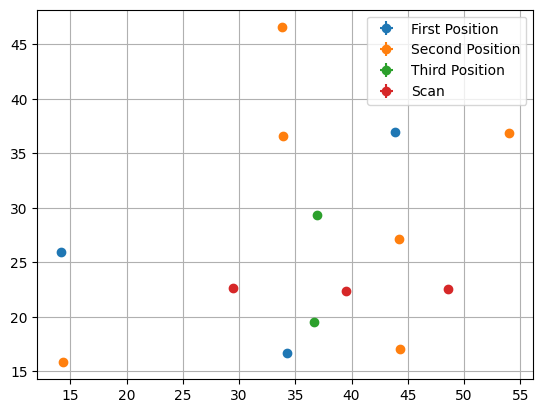

In [5]:
df_first_pos = pad_centers_df_filter[pad_centers_df_filter['run_number'] <= 252]
df_second_pos = pad_centers_df_filter[(pad_centers_df_filter['run_number'] > 252) & (pad_centers_df_filter['run_number'] < 334)]
df_third_pos = pad_centers_df_filter[(pad_centers_df_filter['run_number'] == 334) | (pad_centers_df_filter['run_number'] == 343)]
fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'].to_numpy(), df_first_pos['y_center'].to_numpy(), xerr=df_first_pos['x_center_err'].to_numpy(), yerr=df_first_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='First Position')
ax.errorbar(df_second_pos['x_center'].to_numpy(), df_second_pos['y_center'].to_numpy(), xerr=df_second_pos['x_center_err'].to_numpy(), yerr=df_second_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
ax.errorbar(df_third_pos['x_center'].to_numpy(), df_third_pos['y_center'].to_numpy(), xerr=df_third_pos['x_center_err'].to_numpy(), yerr=df_third_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Third Position')
ax.errorbar(df_scan['x_center'].to_numpy(), df_scan['y_center'].to_numpy(), xerr=df_scan['x_center_err'].to_numpy(), yerr=df_scan['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Scan')
ax.grid(zorder=0)
ax.legend()

In [6]:
class Pad:
    def __init__(self, run_num, pool_num, mm_channel, pad_index=0):
        self.run_number = run_num
        self.pool_num = pool_num
        self.mm_channel = mm_channel
        self.pad_index = pad_index
        self.name = None
        self.x_center = None
        self.y_center = None
        self.df = None

    def __repr__(self):
        return f"Pad(pool_num={self.pool_num}, mm_channel={self.mm_channel}, pad_index={self.pad_index}, x_center={self.x_center}, y_center={self.y_center})\n{self.df}"

In [7]:
pad_runs_2 = [
    266,
    268,
    287,
    302,
    303,
    304
]

pad_names_2 = [
    'J10A',
    'J9B',
    'J16A',
    'J15A',
    'J4B',
    'J3B'
]

pads_2 = []
for pad_i, run_number in enumerate(pad_runs_2):
    df_row = df_second_pos[df_second_pos['run_number'] == run_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(run_number, int(pool_num), mm_channel, pad_i)
    pad_i.name = pad_names_2[pad_i.pad_index]
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{run_number}-Pool{pool_num}-{mm_channel}.csv')
    pads_2.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector2 = SquareDetector(5.0, 54.01, 36.88, np.deg2rad(0.0))
# detector.add_pad(0, -2, -1)
detector2.add_pad(0, -4, -2)
detector2.add_pad(0, -1, -2)
detector2.add_pad(0, -1, -1)
detector2.add_pad(0, -2, 0)
detector2.add_pad(0, -2, +1)

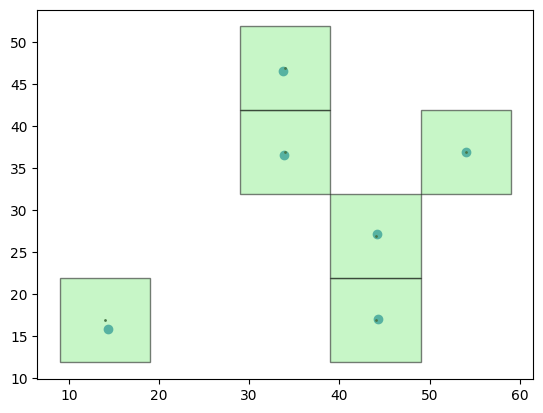

In [8]:
fig, ax = plt.subplots()
ax.errorbar(df_second_pos['x_center'].to_numpy(), df_second_pos['y_center'].to_numpy(), xerr=df_second_pos['x_center_err'].to_numpy(), yerr=df_second_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
# ax.grid(zorder=0)
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [9]:
# Align hex detector to pad centers
def chi_square(params, pads, detector):
    x_center, y_center, angle = params
    detector.set_rotation(np.deg2rad(angle))
    detector.set_center(x_center, y_center)

    chi2_dx, chi2_dy = 0, 0
    for pad in pads:
        det_x, det_y = detector.get_pad_center(pad.pad_index)
        chi2_dx += ((pad.x_center.val - det_x) / pad.x_center.err)**2
        chi2_dy += ((pad.y_center.val - det_y) / pad.y_center.err)**2

    return np.sum(chi2_dx + chi2_dy)


def fit_hex_detector_to_pad_centers(pads, detector, x0=0, y0=0, angle0=0):
    initial_guess = [x0, y0, angle0]
    bounds = ((0, 100), (0, 100), (-20, 20))  # No bounds on x and y, angle between -180 and 180 degrees
    result = minimize(chi_square, initial_guess, args=(pads, detector), bounds=bounds)
    return result

# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_2, detector2, x0=54.01, y0=36.88, angle0=5.5)
print(fit_result)
print(fit_result.x)
detector2.set_center(fit_result.x[0], fit_result.x[1])
detector2.set_rotation(np.deg2rad(fit_result.x[2]))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 29.395444686249444
        x: [ 5.389e+01  3.731e+01  1.857e+00]
      nit: 10
      jac: [-5.294e-05 -8.527e-06 -2.096e-05]
     nfev: 48
     njev: 12
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[53.8864827  37.31457947  1.85699295]


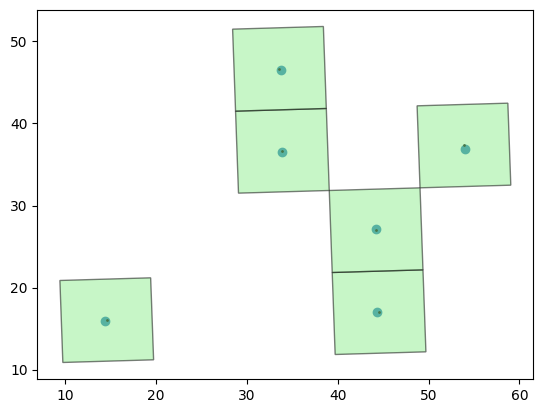

In [10]:
fig, ax = plt.subplots()
ax.errorbar(df_second_pos['x_center'].to_numpy(), df_second_pos['y_center'].to_numpy(), xerr=df_second_pos['x_center_err'].to_numpy(), yerr=df_second_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [11]:
pad_runs_1 = [
    212,
    249,
    252
]

pad_names_1 = [
    'J2B',
    'J14A',
    'J10B'
]

pads_1 = []
for pad_i, run_number in enumerate(pad_runs_1):
    df_row = df_first_pos[df_first_pos['run_number'] == run_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(run_number, int(pool_num), mm_channel, pad_i)
    pad_i.name = pad_names_1[pad_i.pad_index]
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{run_number}-Pool{pool_num}-{mm_channel}.csv')
    pads_1.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector1 = SquareDetector(5.0, 34.2, 16.66, np.deg2rad(0.0))
detector1.add_pad(0, +1, +2)
detector1.add_pad(0, -2, +1)

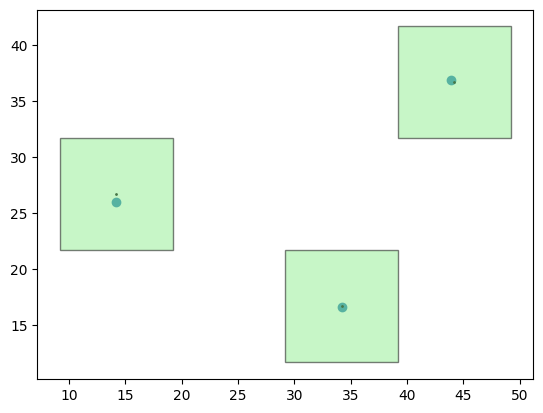

In [12]:
fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'].to_numpy(), df_first_pos['y_center'].to_numpy(), xerr=df_first_pos['x_center_err'].to_numpy(), yerr=df_first_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.317843926635033
        x: [ 3.438e+01  1.664e+01  1.542e+00]
      nit: 9
      jac: [ 2.887e-06 -9.814e-06  2.620e-06]
     nfev: 44
     njev: 11
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[34.3833143  16.63531409  1.54193195]


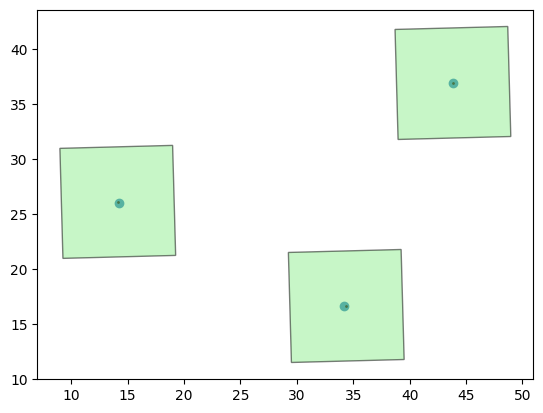

In [13]:
# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_1, detector1, x0=34.2, y0=16.66, angle0=0.0)
print(fit_result)
print(fit_result.x)
detector1.set_center(fit_result.x[0], fit_result.x[1])
detector1.set_rotation(np.deg2rad(fit_result.x[2]))

fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'].to_numpy(), df_first_pos['y_center'].to_numpy(), xerr=df_first_pos['x_center_err'].to_numpy(), yerr=df_first_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [14]:
pad_runs_3 = [
    334,
    343
]

pad_names_3 = [
    'J5B',
    'J8B'
]

pads_3 = []
for pad_i, run_number in enumerate(pad_runs_3):
    df_row = df_third_pos[df_third_pos['run_number'] == run_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(run_number, int(pool_num), mm_channel, pad_i)
    pad_i.name = pad_names_3[pad_i.pad_index]
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{run_number}-Pool{pool_num}-{mm_channel}.csv')
    pads_3.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector3 = SquareDetector(5.0, 36.63, 19.56, np.deg2rad(0.0))
detector3.add_pad(0, 0, +1)

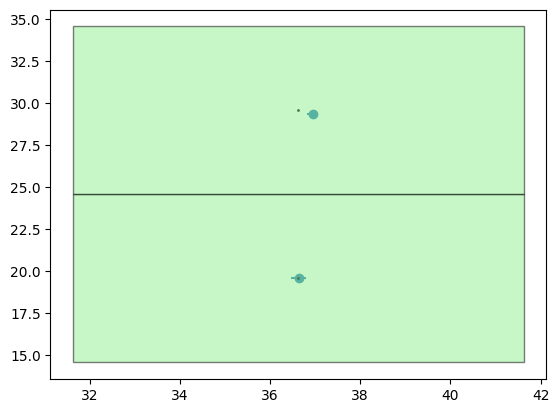

In [15]:
fig, ax = plt.subplots()
ax.errorbar(df_third_pos['x_center'].to_numpy(), df_third_pos['y_center'].to_numpy(), xerr=df_third_pos['x_center_err'].to_numpy(), yerr=df_third_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
# ax.grid(zorder=0)
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2.4750338233243108
        x: [ 3.662e+01  1.952e+01 -1.906e+00]
      nit: 16
      jac: [ 1.785e-05  6.142e-05 -8.615e-06]
     nfev: 80
     njev: 20
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[36.6192457  19.5241224  -1.90553031]


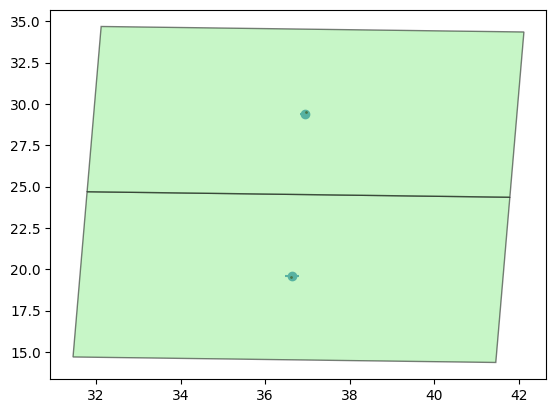

In [16]:
# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_3, detector3, x0=36.63, y0=19.56, angle0=0.0)
print(fit_result)
print(fit_result.x)
detector3.set_center(fit_result.x[0], fit_result.x[1])
detector3.set_rotation(np.deg2rad(fit_result.x[2]))

fig, ax = plt.subplots()
ax.errorbar(df_third_pos['x_center'].to_numpy(), df_third_pos['y_center'].to_numpy(), xerr=df_third_pos['x_center_err'].to_numpy(), yerr=df_third_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Third Position')
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20)

In [17]:
pad_runs_4 = [
    358
]

df_scan_pool8 = df_scan[df_scan['pool_number'] == 8]
pad_channels_4 = [
    'C4',
    'C2'
]

pad_names_4 = [
    'J14B',
    'J11B'
]

pads_4 = []
for pad_i, channel_number in enumerate(pad_channels_4):
    df_row = df_scan_pool8[df_scan_pool8['channel_number'] == channel_number].iloc[0]
    pool_num = df_row['pool_number']
    mm_channel = df_row['channel_number']
    pad_i = Pad(358, int(pool_num), mm_channel, pad_i)
    pad_i.name = pad_names_4[pad_i.pad_index]
    x_center, y_center = Measure(df_row['x_center'], df_row['x_center_err']), Measure(df_row['y_center'], df_row['y_center_err'])
    pad_i.x_center = x_center
    pad_i.y_center = y_center
    pad_i.df = pd.read_csv(f'scan_pad_dfs/Run{358}-Pool{pool_num}-{mm_channel}.csv')
    pads_4.append(pad_i)


# Need to be careful about the pad index, has to match the pads indexing!
detector4 = SquareDetector(5.0, 29.41, 22.67, np.deg2rad(0.0))
detector4.add_pad(0, +1, 0)

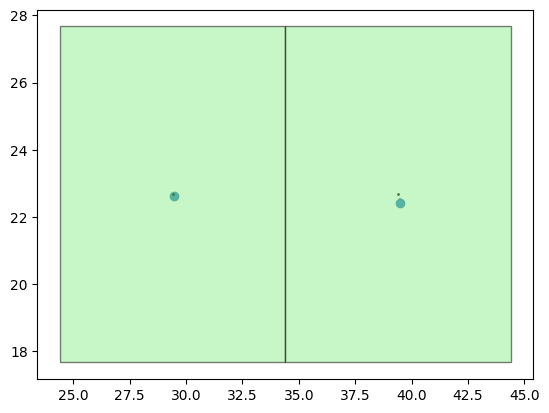

In [18]:
fig, ax = plt.subplots()
ax.errorbar(df_scan_pool8['x_center'].to_numpy(), df_scan_pool8['y_center'].to_numpy(), xerr=df_scan_pool8['x_center_err'].to_numpy(), yerr=df_scan_pool8['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Scan')
# ax.grid(zorder=0)
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.055900621467041944
        x: [ 2.947e+01  2.262e+01 -1.099e+00]
      nit: 12
      jac: [-1.289e-05  1.736e-04  1.831e-06]
     nfev: 60
     njev: 15
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
[29.47029908 22.6189831  -1.09876007]


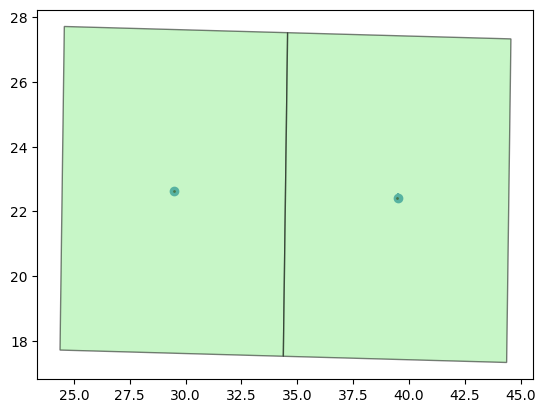

In [19]:
# Fit the hex detector to the pad centers
fit_result = fit_hex_detector_to_pad_centers(pads_4, detector4, x0=29.41, y0=22.67, angle0=0.0)
print(fit_result)
print(fit_result.x)
detector4.set_center(fit_result.x[0], fit_result.x[1])
detector4.set_rotation(np.deg2rad(fit_result.x[2]))

fig, ax = plt.subplots()
ax.errorbar(df_scan_pool8['x_center'].to_numpy(), df_scan_pool8['y_center'].to_numpy(), xerr=df_scan_pool8['x_center_err'].to_numpy(), yerr=df_scan_pool8['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Scan')
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20)

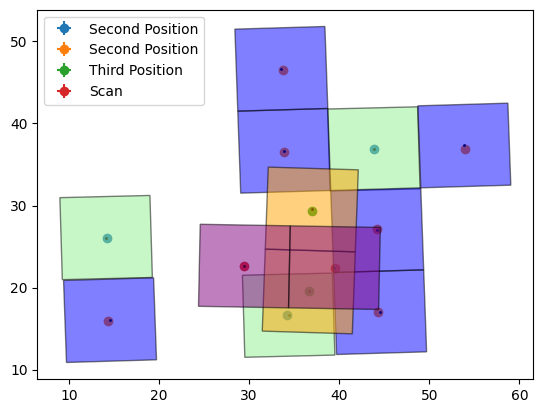

In [20]:
fig, ax = plt.subplots()
ax.errorbar(df_first_pos['x_center'].to_numpy(), df_first_pos['y_center'].to_numpy(), xerr=df_first_pos['x_center_err'].to_numpy(), yerr=df_first_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)
ax.errorbar(df_second_pos['x_center'].to_numpy(), df_second_pos['y_center'].to_numpy(), xerr=df_second_pos['x_center_err'].to_numpy(), yerr=df_second_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Second Position')
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='blue')
ax.errorbar(df_third_pos['x_center'].to_numpy(), df_third_pos['y_center'].to_numpy(), xerr=df_third_pos['x_center_err'].to_numpy(), yerr=df_third_pos['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Third Position')
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='orange')
ax.errorbar(df_scan_pool8['x_center'].to_numpy(), df_scan_pool8['y_center'].to_numpy(), xerr=df_scan_pool8['x_center_err'].to_numpy(), yerr=df_scan_pool8['y_center_err'].to_numpy(), fmt='o', zorder=10, label='Scan')
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='purple')
ax.legend()


In [21]:
det_1_rel_shift = np.array([-2, -2]) * 10
det_2_rel_shift = np.array([0, 0]) * 10
det_3_rel_shift = np.array([-3, -1]) * 10
det_4_rel_shift = np.array([-5, 0]) * 10

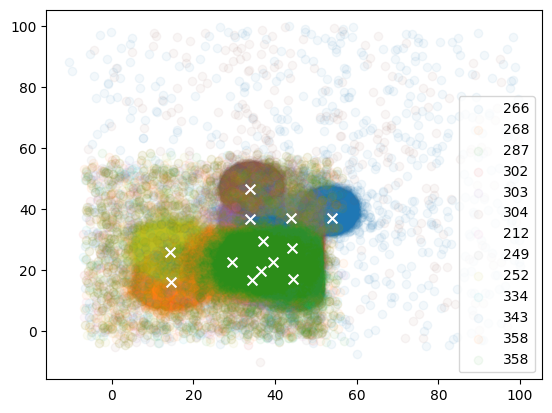

In [22]:
fig, ax = plt.subplots()
for pad_i in range(len(pads_2)):
    sc = ax.scatter(pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'], label=f'{pads_2[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_2[pad_i].x_center.val, pads_2[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
for pad_i in range(len(pads_1)):
    sc = ax.scatter(pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'], label=f'{pads_1[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_1[pad_i].x_center.val, pads_1[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
for pad_i in range(len(pads_3)):
    sc = ax.scatter(pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'], label=f'{pads_3[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_3[pad_i].x_center.val, pads_3[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
for pad_i in range(len(pads_4)):
    sc = ax.scatter(pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'], label=f'{pads_4[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_4[pad_i].x_center.val, pads_4[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
ax.legend()

In [23]:
# Rotate everything to square up detector
for pad_i in range(len(pads_1)):
    pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'] = rotate_points(pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'], -detector1.rotation, detector1.x, detector1.y) + det_1_rel_shift[:, np.newaxis]
    # df_first_pos['x_center'], df_first_pos['y_center'] = rotate_points(df_first_pos['x_center'], df_first_pos['y_center'], -detector1.rotation, detector1.x, detector1.y)
    pads_1[pad_i].x_center, pads_1[pad_i].y_center = rotate_points(pads_1[pad_i].x_center, pads_1[pad_i].y_center, -detector1.rotation, detector1.x, detector1.y) + det_1_rel_shift
detector1.set_center(*det_1_rel_shift)
detector1.set_rotation(np.deg2rad(0.))

for pad_i in range(len(pads_2)):
    pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'] = rotate_points(pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'], -detector2.rotation, detector2.x, detector2.y) + det_2_rel_shift[:, np.newaxis]
    # df_second_pos['x_center'], df_second_pos['y_center'] = rotate_points(df_second_pos['x_center'], df_second_pos['y_center'], -detector2.rotation, detector2.x, detector2.y)
    pads_2[pad_i].x_center, pads_2[pad_i].y_center = rotate_points(pads_2[pad_i].x_center, pads_2[pad_i].y_center, -detector2.rotation, detector2.x, detector2.y) + det_2_rel_shift
detector2.set_center(*det_2_rel_shift)
detector2.set_rotation(np.deg2rad(0.))

for pad_i in range(len(pads_3)):
    pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'] = rotate_points(pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'], -detector3.rotation, detector3.x, detector3.y) + det_3_rel_shift[:,np.newaxis]
    # df_third_pos['x_center'], df_third_pos['y_center'] = rotate_points(df_third_pos['x_center'], df_third_pos['y_center'], -detector3.rotation, detector3.x, detector3.y)
    pads_3[pad_i].x_center, pads_3[pad_i].y_center = rotate_points(pads_3[pad_i].x_center, pads_3[pad_i].y_center, -detector3.rotation, detector3.x, detector3.y) + det_3_rel_shift
detector3.set_center(*det_3_rel_shift)
detector3.set_rotation(np.deg2rad(0.))

for pad_i in range(len(pads_4)):
    pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'] = rotate_points(pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'], -detector4.rotation, detector4.x, detector4.y) + det_4_rel_shift[:,np.newaxis]
    # df_third_pos['x_center'], df_third_pos['y_center'] = rotate_points(df_third_pos['x_center'], df_third_pos['y_center'], -detector3.rotation, detector3.x, detector3.y)
    pads_4[pad_i].x_center, pads_4[pad_i].y_center = rotate_points(pads_4[pad_i].x_center, pads_4[pad_i].y_center, -detector4.rotation, detector4.x, detector4.y) + det_4_rel_shift
detector4.set_center(*det_4_rel_shift)
detector4.set_rotation(np.deg2rad(0.))

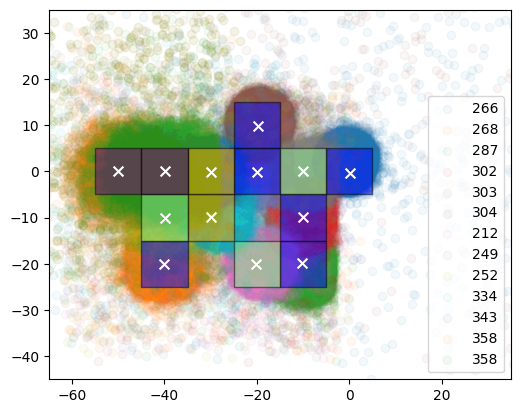

In [24]:
fig, ax = plt.subplots()
for pad_i in range(len(pads_2)):
    sc = ax.scatter(pads_2[pad_i].df['hitX'], pads_2[pad_i].df['hitY'], label=f'{pads_2[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_2[pad_i].x_center.val, pads_2[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=5, pad_colors='blue')

for pad_i in range(len(pads_1)):
    sc = ax.scatter(pads_1[pad_i].df['hitX'], pads_1[pad_i].df['hitY'], label=f'{pads_1[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_1[pad_i].x_center.val, pads_1[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=5)

for pad_i in range(len(pads_3)):
    sc = ax.scatter(pads_3[pad_i].df['hitX'], pads_3[pad_i].df['hitY'], label=f'{pads_3[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_3[pad_i].x_center.val, pads_3[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=5, pad_colors='orange')

for pad_i in range(len(pads_3)):
    sc = ax.scatter(pads_4[pad_i].df['hitX'], pads_4[pad_i].df['hitY'], label=f'{pads_4[pad_i].run_number}', alpha=0.05)
    ax.scatter(pads_4[pad_i].x_center.val, pads_4[pad_i].y_center.val, marker='x', color='white', s=50, zorder=10)
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=5, pad_colors='purple')

ax.legend()
ax.set_ylim(-45, 35)
ax.set_xlim(-65, 35)
ax.set_aspect('equal')

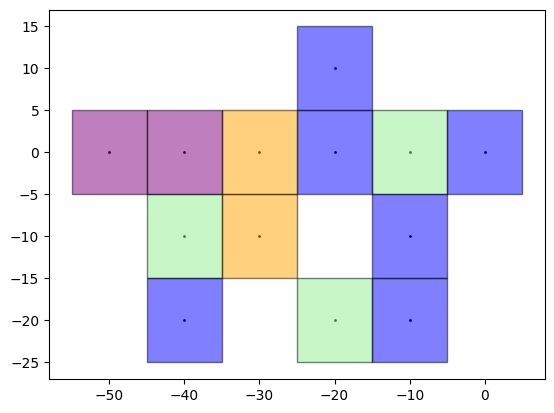

In [25]:
fig, ax = plt.subplots()
# ax.errorbar(df_first_pos['x_center'], df_first_pos['y_center'], xerr=df_first_pos['x_center_err'], yerr=df_first_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector1.plot_detector(ax_in=ax, global_coords=True, zorder=20)
# ax.errorbar(df_second_pos['x_center'], df_second_pos['y_center'], xerr=df_second_pos['x_center_err'], yerr=df_second_pos['y_center_err'], fmt='o', zorder=10, label='Second Position')
detector2.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='blue')
# ax.errorbar(df_third_pos['x_center'], df_third_pos['y_center'], xerr=df_third_pos['x_center_err'], yerr=df_third_pos['y_center_err'], fmt='o', zorder=10, label='Third Position')
detector3.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='orange')
# ax.errorbar(df_scan_pool8['x_center'], df_scan_pool8['y_center'], xerr=df_scan_pool8['x_center_err'], yerr=df_scan_pool8['y_center_err'], fmt='o', zorder=10, label='Scan')
detector4.plot_detector(ax_in=ax, global_coords=True, zorder=20, pad_colors='purple')

In [26]:
all_pads = [pads_1, pads_2, pads_3, pads_4]

n_event_bins: 375
n_event_bins: 381
n_event_bins: 173
n_event_bins: 300
n_event_bins: 249
n_event_bins: 384
n_event_bins: 507
n_event_bins: 387
n_event_bins: 355
n_event_bins: 346
n_event_bins: 227
n_event_bins: 191
n_event_bins: 304


(-0.05, 0.1)

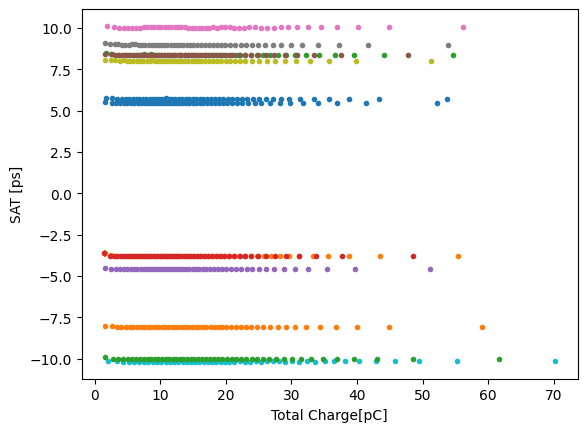

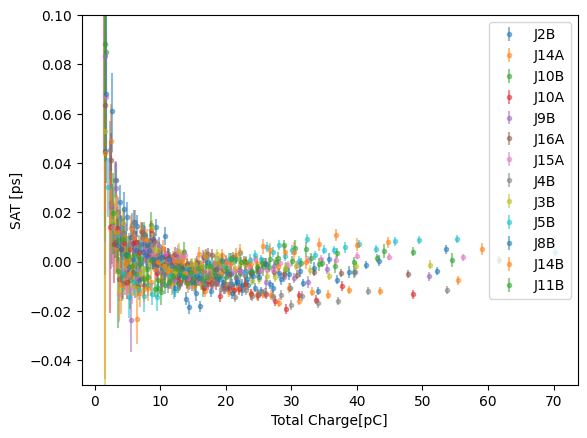

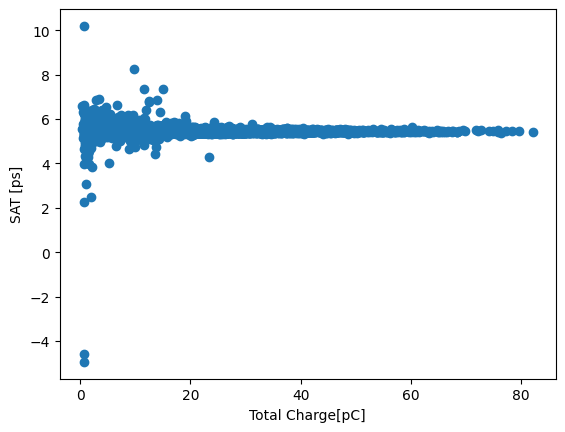

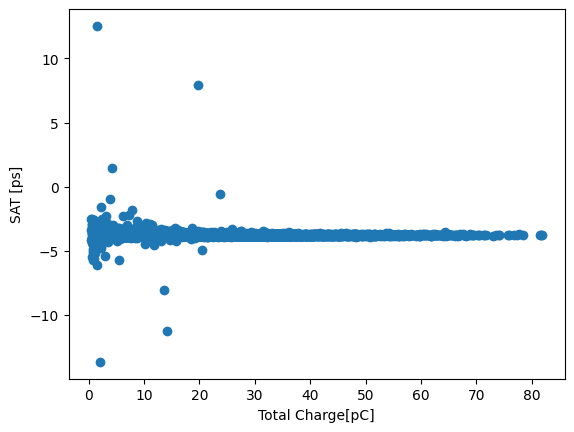

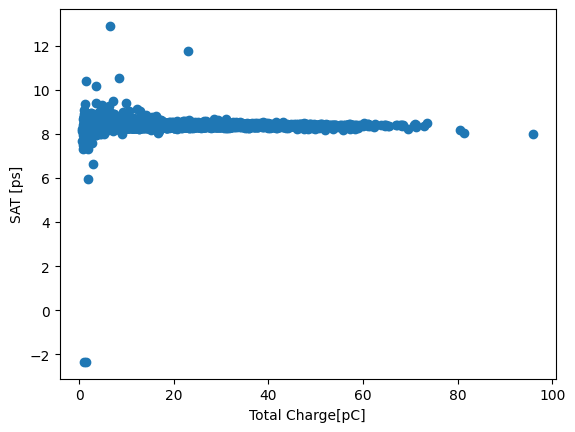

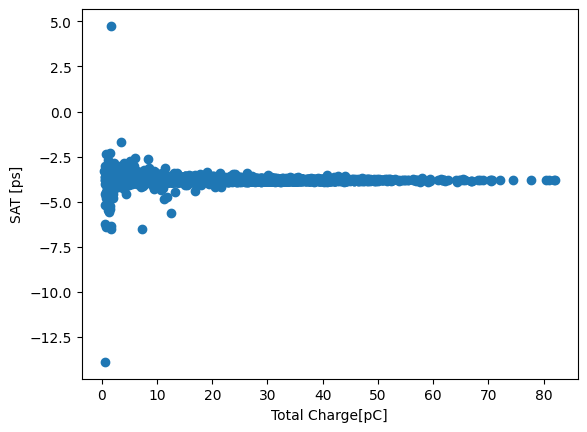

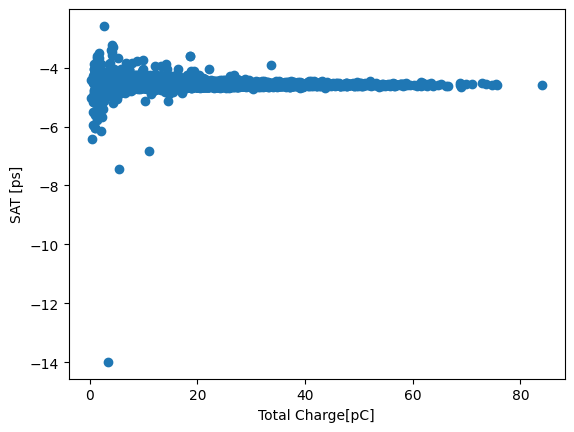

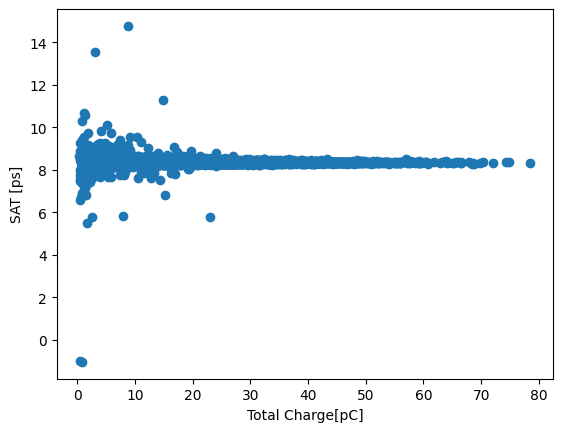

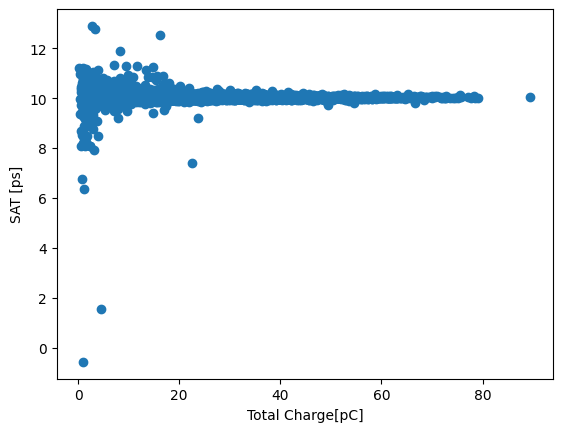

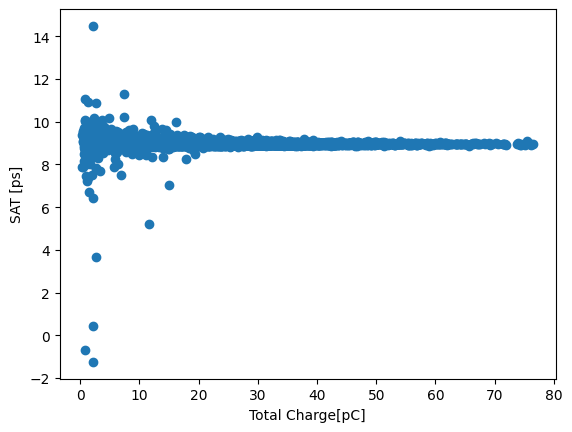

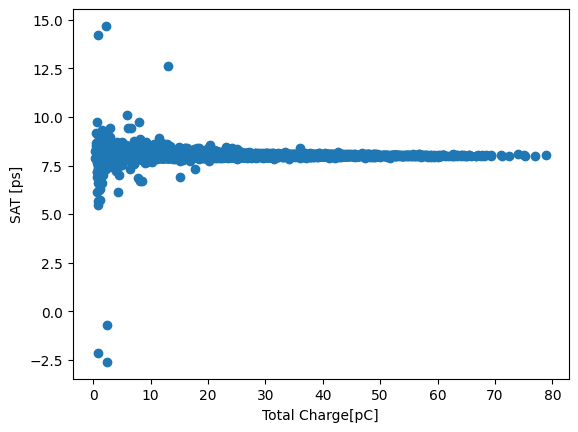

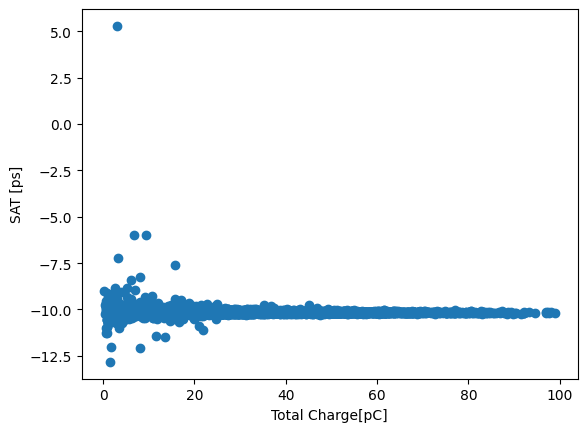

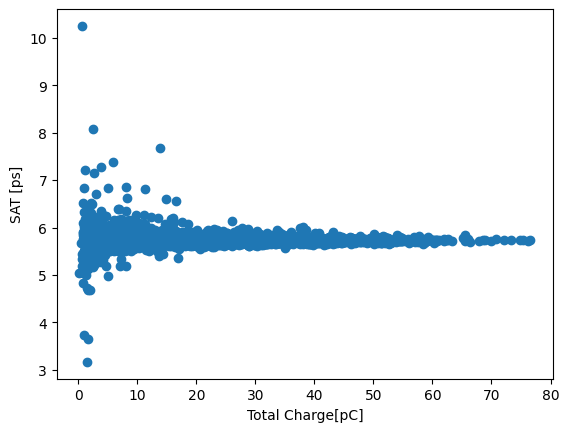

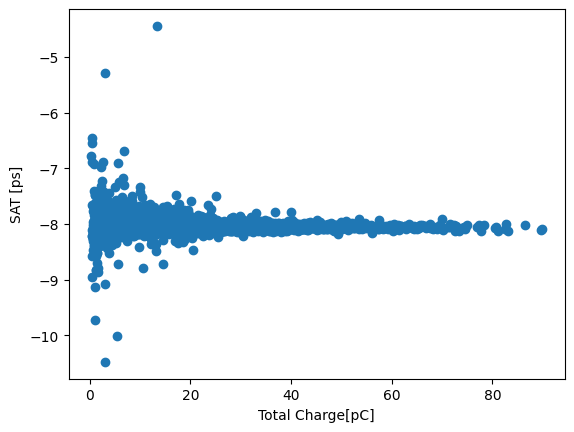

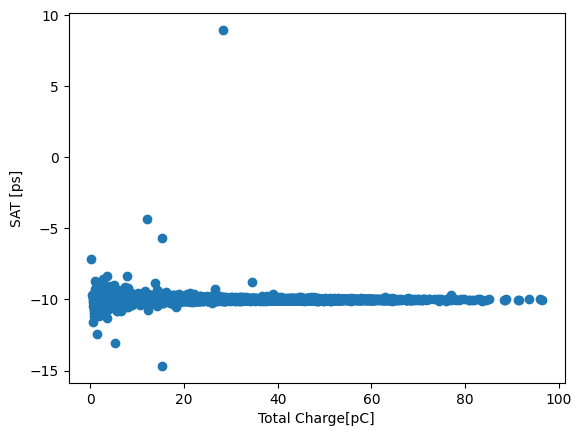

In [27]:
time_walk_nbins = 50  # For SAT vs charge
n_charge_bins = 50  # For resolution vs charge fits
abs_t_max = 15  # Quick and sloppy way to remove outliers

time_walk_func = time_walk_double_exponential
p0_time_walk = [1.0, -0.1, 0.5, -0.1, 4] #ampl1, decay1, amp2, decay2, bsl

p0_resol = [30, -0.1, 10, -0.05, 20]
resol_func = time_walk_double_exponential
resolution_correction_to_use = 'Corrected Gaus'  # Correction to use moving forward

binning_type = 'equal_stats'
percentile_cut=(2, 98)
r_square = 5  # mm

fig, ax = plt.subplots()
fig2, ax2 = plt.subplots()
for pads in all_pads:
    for pad_i in pads:
        pad_idx = pad_i.pad_index
        center_mask = (
            (pad_i.df['hitX'] >= pad_i.x_center - r_square) & (pad_i.df['hitX'] <= pad_i.x_center + r_square) &
            (pad_i.df['hitY'] >= pad_i.y_center - r_square) & (pad_i.df['hitY'] <= pad_i.y_center + r_square)
        )
        df_pad = pad_i.df[center_mask & (np.abs(pad_i.df['time_diff']) < abs_t_max)]

        time_diffs_i, charges_i = df_pad['time_diff'], df_pad['totcharge']
        charges_i, time_diffs_i = filter_sort_charges_time_diffs(time_diffs_i, charges_i)
        fig3, ax3 = plt.subplots()
        ax3.scatter(charges_i, time_diffs_i)
        ax3.set_xlabel('Total Charge[pC]')
        ax3.set_ylabel('SAT [ps]')
        avg_charges, med_time_diffs, std_err_time_diffs, gaus_means, gaus_mean_errs = get_time_walk_binned(time_diffs_i, charges_i, binning_type, time_walk_nbins, percentile_cut)
        ax.errorbar(avg_charges, gaus_means, yerr=gaus_mean_errs, fmt='.', label=f'Pad {pad_idx}')
        ax.set_xlabel('Total Charge[pC]')
        ax.set_ylabel('SAT [ps]')
        ax2.errorbar(avg_charges, np.array(gaus_means) - np.mean(gaus_means), yerr=gaus_mean_errs, fmt='.', alpha=0.5, label=pad_i.name)
        ax2.set_xlabel('Total Charge[pC]')
        ax2.set_ylabel('SAT [ps]')
        if np.max(gaus_mean_errs) > 1000:
            print(f'Pad {pad_idx} is too big -- {np.max(gaus_mean_errs)}')
ax2.legend()
ax2.set_ylim(bottom=-0.05, top=0.1)

In [28]:
scan_radius = 1.0
min_events_per_circle = 200

n_steps_2D = 300
scan_xs = np.linspace(-60, 10, n_steps_2D + 1)
scan_ys = np.linspace(-30, 20, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

pads_scan_resolutions, pads_scan_means, pads_scan_events = [], [], []
for pads in all_pads:
    for pad_i in pads:
        time_diffs, hit_xs, hit_ys = pad_i.df['time_diff_cor'], pad_i.df['hitX'], pad_i.df['hitY']
        scan_resolutions, scan_means, events = get_circle_scan(time_diffs, hit_xs, hit_ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle, ns_to_ps=True, percentile_cuts=(2, 98), nsigma_filter=3, shape='square', plot=False)
        pads_scan_resolutions.append(scan_resolutions)
        pads_scan_means.append(scan_means)
        pads_scan_events.append(events)

/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/local/home/dn277127/PycharmProjects/sPHENIX_Vernier_Scan_Simulation

scan_res min: 26.046665104817237, max: 144.66641933370857
res_vmax: 67.65170868990973
mean_vmin: -10.327926997492266, mean_vmax: 90.99532304872695


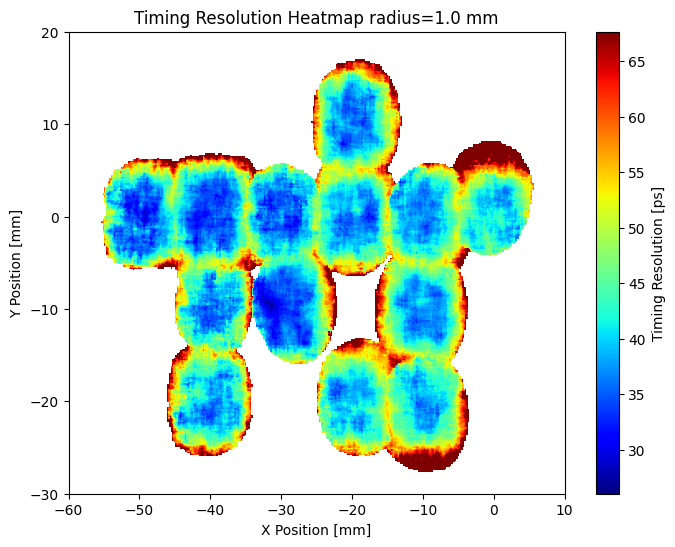

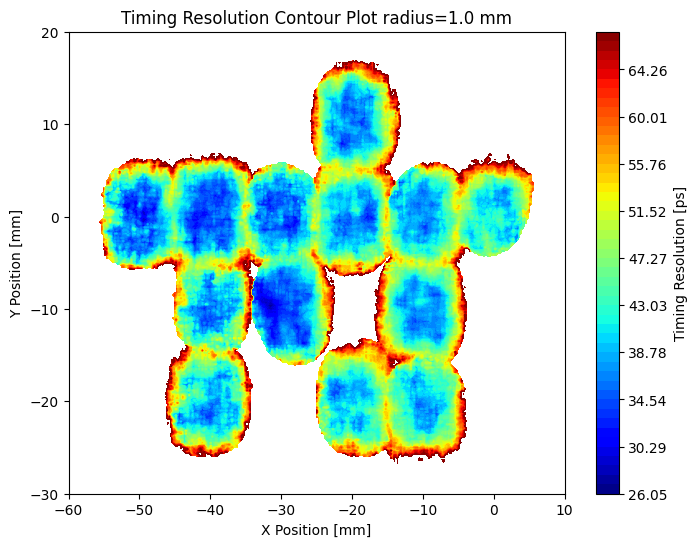

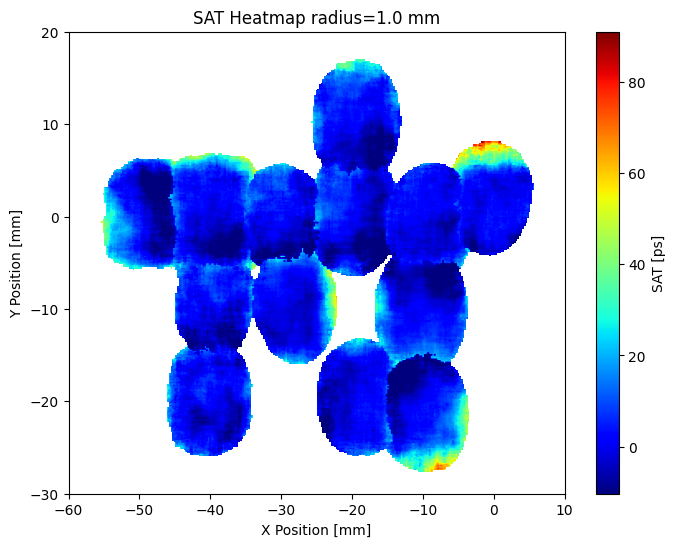

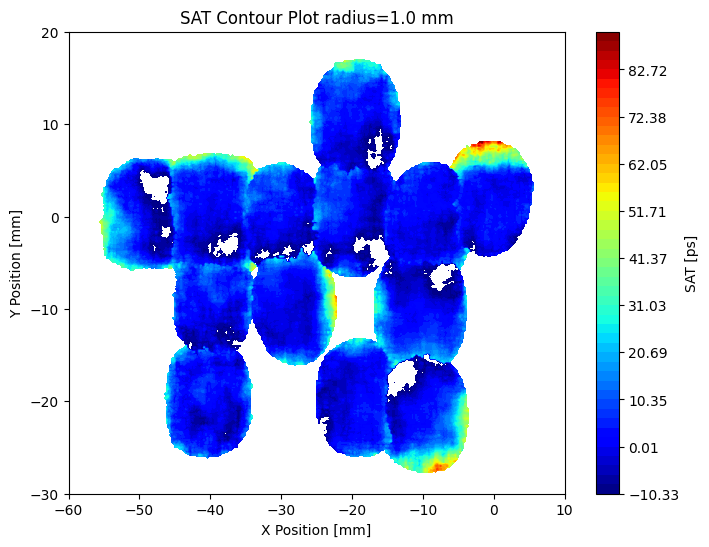

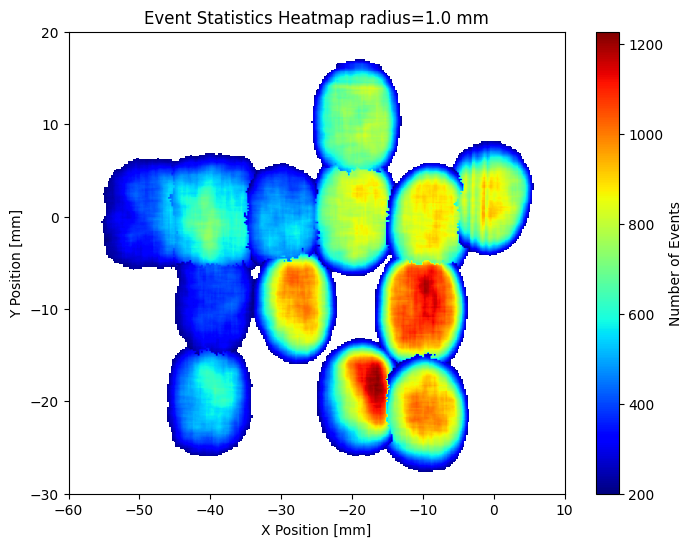

In [29]:
res_array = np.array(pads_scan_resolutions)  # shape: (n_pads, n_scans)
mean_array = np.array(pads_scan_means)
event_array = np.array(pads_scan_events)

n_scans = res_array.shape[1]
best_pad_indices = np.full(n_scans, -1, dtype=int)  # -1 means "no valid pad"
best_resolutions = np.full(n_scans, Measure(np.nan, np.nan))
best_means = np.full(n_scans, Measure(np.nan, np.nan))
best_events = np.full(n_scans, np.nan)

for i in range(n_scans):
    scan_res = np.array([res.val for res in res_array[:, i]])

    if np.all(np.isnan(scan_res)):
        continue  # leave as NaN / -1
    best_pad = np.nanargmin(scan_res)

    best_pad_indices[i] = best_pad
    best_resolutions[i] = res_array[best_pad, i]
    best_means[i] = mean_array[best_pad, i]
    best_events[i] = event_array[best_pad, i]

plot_2D_circle_scan(best_resolutions, best_means, scan_xs, scan_ys, scan_events=best_events, radius=scan_radius, percentile_filter=[0, 95])

In [32]:
scan_radius = 1.0
min_events_per_circle = 200

n_steps_2D = 50
scan_xs = np.linspace(-60, 10, n_steps_2D + 1)
scan_ys = np.linspace(-30, 20, n_steps_2D + 1)

# Generate mesh grid
x_mesh, y_mesh = np.meshgrid(scan_xs, scan_ys)
xy_pairs = list(zip(x_mesh.ravel(), y_mesh.ravel()))  # Flatten to list of (x, y) pairs

pads_scan_efficiencies, pads_scan_eff_events = [], []
for pads in all_pads:
    for pad_i in pads:
        time_diff_cors = np.where((pad_i.df['time_diff_cor'] > -1) & ((pad_i.df['time_diff_cor'] > -1)), pad_i.df['time_diff_cor'], np.nan)
        hits, hit_xs, hit_ys = ~np.isnan(pad_i.df['time_diff_cor']), pad_i.df['hitX'], pad_i.df['hitY']
        efficiencies, events = get_circle_efficiency_scan(hits, hit_xs, hit_ys, xy_pairs, radius=scan_radius, min_events=min_events_per_circle)
        pads_scan_efficiencies.append(efficiencies)
        pads_scan_eff_events.append(events)

ValueError: Contour levels must be increasing

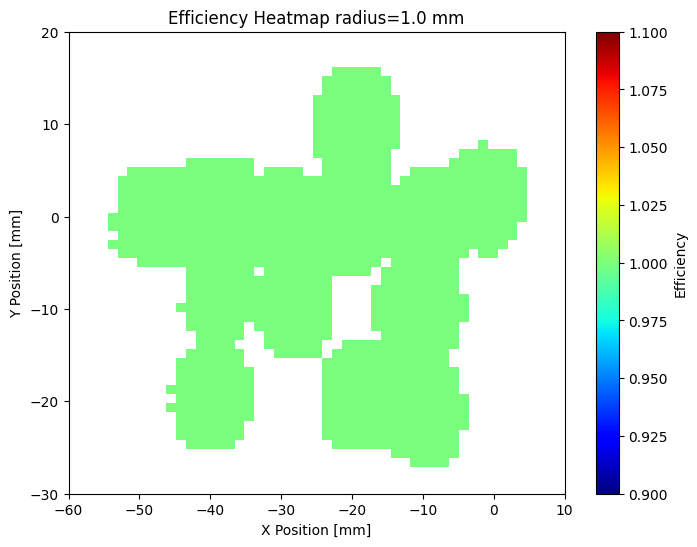

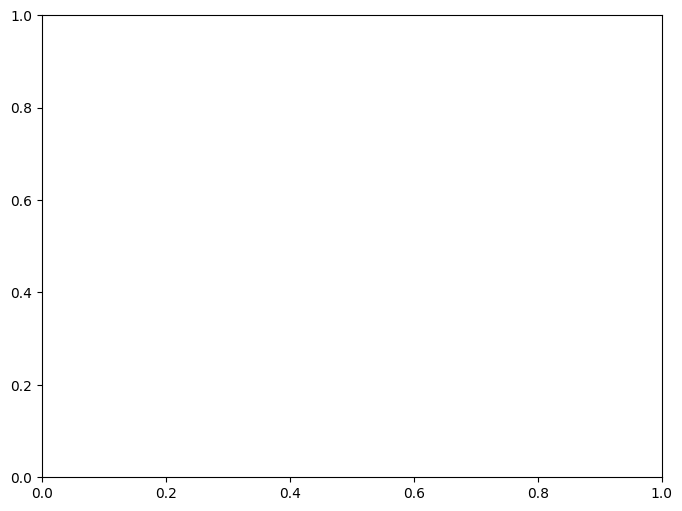

In [34]:
eff_array = np.array(pads_scan_efficiencies)  # shape: (n_pads, n_scans)
event_eff_array = np.array(pads_scan_eff_events)

n_scans = eff_array.shape[1]
best_pad_indices = np.full(n_scans, -1, dtype=int)  # -1 means "no valid pad"
best_efficiencies = np.full(n_scans, np.nan)
best_eff_events = np.full(n_scans, np.nan)

for i in range(n_scans):
    scan_eff = np.array(eff_array[:, i])

    if np.all(np.isnan(scan_eff)):
        continue  # leave as NaN / -1
    best_pad = np.nanargmax(scan_eff)

    best_pad_indices[i] = best_pad
    best_efficiencies[i] = eff_array[best_pad, i]
    best_eff_events[i] = event_eff_array[best_pad, i]

plot_2D_efficiency_scan(best_efficiencies, scan_xs, scan_ys, scan_events=best_eff_events, radius=scan_radius)